## Recognising the numbers in the car number plates!

In this section, we pick up one if the most basic classification tasks. Given an image of a digit (0-9), the task is to classify them. The dataset used is the MNIST.

Colaboratory notebooks are stored in [Google Drive](https://drive.google.com) and can be shared just as you would with Google Docs or Sheets. Colaboratory is free to use.

For more information, see our [FAQ](https://research.google.com/colaboratory/faq.html).

## Using convolutional neural network (CNN)

First, we must convince ourselves that CNN is the right choice for such a task. Refer to the lecture slides. In general, this is a well-studied problem and we expect the difficulty of this to be known to a large extent. Such problems typically involve hyper-parameters that are known to be within certain range for the approach to work. What are all the hyper-parameters here?



### Import the modules

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
rng = np.random

### Import the data



In [2]:


from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Set some hyperparameters

Remember we discussed in the class how setting up hyper-parameters could be a non-trivial task. Our current example is simple hence we would not bother too much on it. In any real world application, the number of hyper-parameters and their sensitivities can determine which approach we end up choosing.

In [0]:
# for the learning
alpha = 0.001
batch_size = 128
num_steps = 2000

# for the network itself
dim_input = 784 # the images are 28 * 28
dim_out = 10 # classes are: (0-9 digits)
dropout_rate = 0.25 # dropout probability

### Define the network topology

When determining any neural network, we need to decide number of layers and activation function. CNN on top of this would also have other parameters.

In [0]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # con layer with filter=32, kernel width=5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # do max pooling with stride=2, kernel width=2 
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # con layer with filter=64, kernel width=3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # do max pooling with stride=2, kernel width=2 
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # dense fully connected layer
        fc1 = tf.layers.dense(fc1, 1024)
        # apply dropout. Why is training flag needed?
        fc1 = tf.layers.dropout(fc1, rate=dropout_rate, training=is_training)

        # output layer
        out = tf.layers.dense(fc1, n_classes)

    return out

### Define the estimator



In [15]:
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, dim_out, dropout_rate, reuse=False, is_training=True)
    logits_test = conv_net(features, dim_out, dropout_rate, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=alpha)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs
  
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpdtgmwa_z', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb7e5464748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Define the input



In [0]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

### Train the model on the input

In [17]:
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpdtgmwa_z/model.ckpt.
INFO:tensorflow:loss = 2.2957673, step = 1
INFO:tensorflow:global_step/sec: 7.43569
INFO:tensorflow:loss = 0.20785582, step = 101 (13.450 sec)
INFO:tensorflow:global_step/sec: 7.15507
INFO:tensorflow:loss = 0.08965327, step = 201 (13.976 sec)
INFO:tensorflow:global_step/sec: 7.25465
INFO:tensorflow:loss = 0.049748145, step = 301 (13.784 sec)
INFO:tensorflow:global_step/sec: 7.23065
INFO:tensorflow:loss = 0.061013207, step = 401 (13.830 sec)
INFO:tensorflow:global_step/sec: 7.29998
INFO:tensorflow:loss = 0.044861794, step = 501 (13.699 sec)
INFO:tensorflow:global_step/sec: 7.24348
INFO:tensorflow:loss = 0.05258227, step = 601 (13.810 sec)
INFO:tensorflow:global_step/sec: 7.26377
I

### Evaluate the learned model


In [18]:
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-23-18:43:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdtgmwa_z/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-23-18:43:21
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9885, global_step = 2000, loss = 0.03749781


{'accuracy': 0.9885, 'global_step': 2000, 'loss': 0.03749781}

### Verify the learner

Verify is a loaded word. We saw how the good thing about the NN (that they encapsulate all the non-lineraties within them) is also the bad thing about them (extremely hard to verify). Here, we seek to do some simple checking:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpdtgmwa_z/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


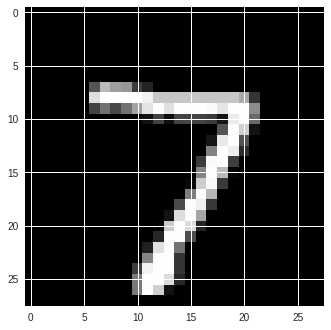

Model prediction: 7


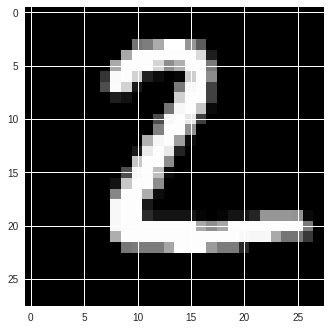

Model prediction: 2


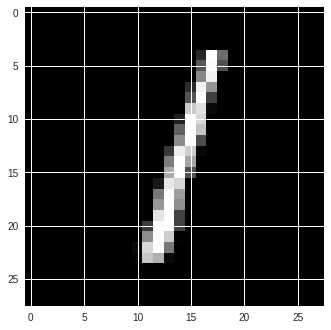

Model prediction: 1


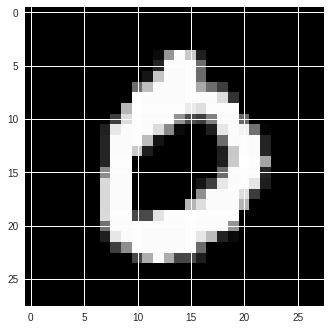

Model prediction: 0


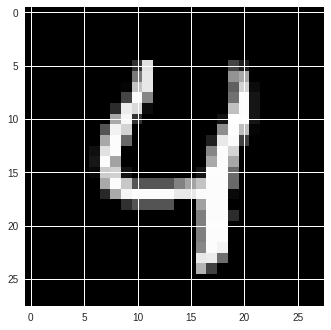

Model prediction: 4


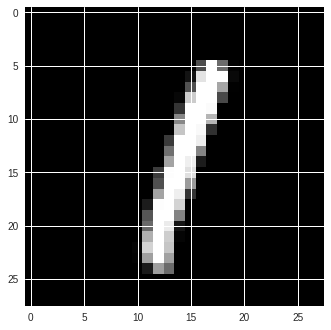

Model prediction: 1


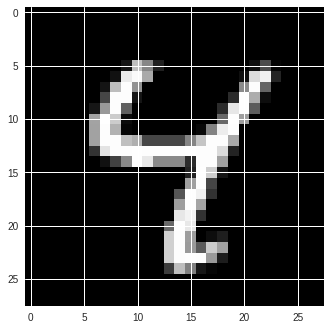

Model prediction: 4


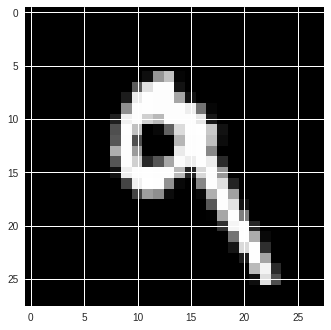

Model prediction: 9


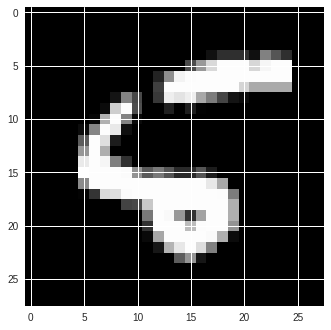

Model prediction: 5


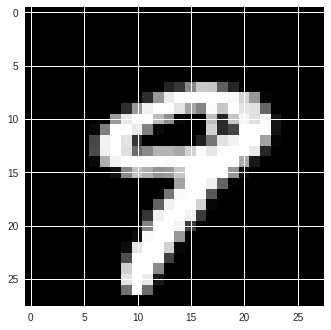

Model prediction: 9


In [20]:
# Predict randomly chosen images
n_images = 10
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
y_hat = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", y_hat[i])

## For more information:
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Markdown guide](/notebooks/markdown_guide.ipynb)
- [Charts](/notebooks/charts.ipynb)
- [Widgets](/notebooks/widgets.ipynb)
- [Loading and saving data: local files, Drive, Sheets, Google Cloud Storage](/notebooks/io.ipynb)
- [Example Google Cloud BigQuery notebook](/notebooks/bigquery.ipynb)
- [TensorFlow with GPU](/notebooks/gpu.ipynb)